# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Recommender Model Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
%pip install scikit-learn numpy pandas optuna tqdm plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import optuna
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the cleaned dataset

In [3]:
# Define the same column names from the EDA notebook
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']
label_cols = ['country_of_origin', 'variety', 'processing_method']

### Cleaned dataset

In [4]:
# Read the cleaned dataset
loaded_df = pd.read_csv('datasets/preprocessed_coffee_data.csv')

# Split into X and y using these column names
X = loaded_df[feature_cols].to_numpy()
y = loaded_df[label_cols].to_numpy()

## Generate the user-item matrices

In [5]:
def create_interaction_matrices(df):
    """
    Creates user-item matrices while handling duplicate ratings by taking their mean.
    This ensures each certification body has one rating per unique item.
    """
    # Define  attributes and variables
    sensory_attributes = [
        'aroma', 'flavor', 'aftertaste', 'acidity',
        'body', 'balance', 'uniformity', 'clean_cup', 'sweetness'
    ]
    
    coffee_variables = [
        'country_of_origin', 'variety', 'processing_method'
    ]
    
    # Initialize dictionary to store all matrices
    interaction_matrices = {
        'country_of_origin': {},
        'variety': {},
        'processing_method': {}
    }
    
    # For each coffee variable, create separate matrices for each sensory attribute
    for coffee_var in coffee_variables:
        for sensory_attr in sensory_attributes:
            # First, group by certification body and coffee variable
            # Then take the mean of the sensory attribute
            aggregated_ratings = df.groupby(
                ['certification_body', coffee_var])[sensory_attr].mean().reset_index()
            
            # Now create the pivot table with the aggregated data
            matrix = aggregated_ratings.pivot(
                index='certification_body',
                columns=coffee_var,
                values=sensory_attr
            )
            
            # Store the matrix
            interaction_matrices[coffee_var][sensory_attr] = matrix
    
    return interaction_matrices

# Let's also add a function to check the data before creating matrices
def analyze_raw_data(df):
    """
    Analyzes the raw data to identify potential issues with duplicates
    """
    print("\nAnalyzing raw data structure:")
    
    for var in ['country_of_origin', 'variety', 'processing_method']:
        # Count how many ratings each certification body gave for each unique item
        duplicates = df.groupby(['certification_body', var]).size().reset_index(name='count')
        multiple_ratings = duplicates[duplicates['count'] > 1]
        
        if len(multiple_ratings) > 0:
            print(f"\nFound multiple ratings for {var}:")
            print(f"Number of duplicate combinations: {len(multiple_ratings)}")
            print("Example of duplicates:")
            print(multiple_ratings.head())
    
    return duplicates

# Use these functions
# First, analyze the data to understand the duplicate structure
duplicates_analysis = analyze_raw_data(loaded_df)

# Then create the matrices with automatic handling of duplicates
matrices = create_interaction_matrices(loaded_df)

# Let's examine one of the resulting matrices
print("\nExample matrix structure (Aroma ratings for countries):")
print(matrices['country_of_origin']['aroma'].head())


Analyzing raw data structure:

Found multiple ratings for country_of_origin:
Number of duplicate combinations: 42
Example of duplicates:
  certification_body country_of_origin  count
0             user_1       East Africa     15
1            user_10       East Africa     32
2            user_11   Central America     60
3            user_12   Central America     38
4            user_12          Colombia      2

Found multiple ratings for variety:
Number of duplicate combinations: 87
Example of duplicates:
  certification_body  variety  count
2             user_1    Other     13
3            user_10  Bourbon      3
5            user_10    Other     11
6            user_10     SL14     17
8            user_11   Catuai     21

Found multiple ratings for processing_method:
Number of duplicate combinations: 56
Example of duplicates:
  certification_body processing_method  count
0             user_1     Natural / Dry     10
1             user_1      Washed / Wet      5
2            user_10  

## Split the dataset into training and test sets

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def create_train_test_splits(interaction_matrices, test_size=0.2, random_state=0):
    """
    Creates train-test splits for coffee recommendation matrices.
    
    For each combination of coffee variable (country, variety, processing) and 
    sensory attribute, create separate training and test matrices while 
    preserving the user-item interaction structure.
    
    Parameters:
    interaction_matrices: Dictionary of interaction matrices
    test_size: Proportion of ratings to hold out for testing (default 0.2 for 80-20 split)
    random_state: Random seed for reproducibility
    
    Returns:
    train_matrices: Dictionary of training matrices
    test_matrices: Dictionary of test matrices
    """
    # Initialize dictionaries to store splits
    train_matrices = {
        'country_of_origin': {},
        'variety': {},
        'processing_method': {}
    }
    test_matrices = {
        'country_of_origin': {},
        'variety': {},
        'processing_method': {}
    }
    
    # For each coffee variable (country, variety, processing)
    for coffee_var in interaction_matrices.keys():
        # For each sensory attribute matrix
        for sensory_attr, matrix in interaction_matrices[coffee_var].items():
            # Convert matrix to long format for splitting
            ratings_long = matrix.reset_index().melt(
                id_vars=['certification_body'],
                var_name=coffee_var,
                value_name=sensory_attr
            )
            
            # Remove missing values before splitting
            ratings_long = ratings_long.dropna()
            
            # Split the data
            train_data, test_data = train_test_split(
                ratings_long,
                test_size=test_size,
                random_state=random_state
            )
            
            # Convert back to matrix format
            train_matrix = train_data.pivot(
                index='certification_body',
                columns=coffee_var,
                values=sensory_attr
            )
            
            test_matrix = test_data.pivot(
                index='certification_body',
                columns=coffee_var,
                values=sensory_attr
            )
            
            # Store the splits
            train_matrices[coffee_var][sensory_attr] = train_matrix
            test_matrices[coffee_var][sensory_attr] = test_matrix
            
            # Print information about the split
            # print(f"\nSplit information for {coffee_var} - {sensory_attr}:")
            # print(f"Training set shape: {train_matrix.shape}")
            # print(f"Test set shape: {test_matrix.shape}")
            # print(f"Training set sparsity: {train_matrix.isna().sum().sum() / (train_matrix.shape[0] * train_matrix.shape[1]):.2%}")
            # print(f"Test set sparsity: {test_matrix.isna().sum().sum() / (test_matrix.shape[0] * test_matrix.shape[1]):.2%}")
    
    return train_matrices, test_matrices

In [7]:
train_matrices, test_matrices = create_train_test_splits(matrices)

## Recommender Systems
- Truncated SVD
- Non-negative Matrix Factorization

In [8]:
from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np
import pandas as pd

class CoffeeRecommender:
    def __init__(self, model='svd', n_factors=5):
        """
        Initialize the recommender system with choice of factorization model.
        
        Parameters:
        model: str, either 'svd' (for TruncatedSVD) or 'nmf'
        n_factors: int, number of latent factors to use
        """
        self.model_type = model.lower()
        self.n_factors = n_factors
        
        # Initialize model containers
        self.trained_models = {
            'country_of_origin': {},
            'variety': {},
            'processing_method': {}
        }
        
        # Store means for centering data
        self.rating_means = {
            'country_of_origin': {},
            'variety': {},
            'processing_method': {}
        }
        
        if self.model_type not in ['svd', 'nmf']:
            raise ValueError("Model must be either 'svd' or 'nmf'")
    
    def _prepare_matrix_for_factorization(self, matrix):
        """
        Prepare the interaction matrix for factorization.
        TruncatedSVD handles missing values differently than regular SVD,
        so'll fill them with 0s for both models.
        """
        # For both SVD and NMF, fill missing values with 0
        matrix_mean = matrix.mean().mean()
        return matrix.fillna(0), matrix_mean
    
    def _apply_factorization(self, matrix):
        """
        Apply either TruncatedSVD or NMF to the prepared matrix.
        Now includes dimension checking to avoid errors.
        """
        # Get the minimum dimension of the matrix
        min_dim = min(matrix.shape[1], matrix.shape[0])
        
        # Adjust n_factors if it's too large
        n_factors = min(self.n_factors, min_dim - 1)
        
        if self.model_type == 'svd':
            svd = TruncatedSVD(
                n_components=n_factors,
                random_state=0
            )
            
            user_factors = pd.DataFrame(
                svd.fit_transform(matrix),
                index=matrix.index
            )
            
            item_factors = pd.DataFrame(
                svd.components_.T,
                index=matrix.columns
            )
            
            return user_factors, item_factors
        else:
            model = NMF(
                n_components=n_factors,
                init='random',
                random_state=0,
                max_iter=2000
            )
            
            user_factors = pd.DataFrame(
                model.fit_transform(matrix),
                index=matrix.index
            )
            
            item_factors = pd.DataFrame(
                model.components_.T,
                index=matrix.columns
            )
            
            return user_factors, item_factors
    
    def train(self, interaction_matrices):
        """
        Train the recommender system on all interaction matrices.
        Now includes dimension checking and reporting.
        """
        for coffee_var in interaction_matrices.keys():
            # print(f"\nTraining models for {coffee_var}")
            
            for sensory_attr, matrix in interaction_matrices[coffee_var].items():
                # Report matrix dimensions
                n_users, n_items = matrix.shape
                min_dim = min(n_items, n_users) - 1
                actual_factors = min(self.n_factors, min_dim)
                
                # print(f"Processing {sensory_attr}...")
                # print(f"Matrix dimensions: {n_users} users × {n_items} items")
                # print(f"Using {actual_factors} factors (adjusted from {self.n_factors})")
                
                prepared_matrix, mean_rating = self._prepare_matrix_for_factorization(matrix)
                self.rating_means[coffee_var][sensory_attr] = mean_rating
                
                user_factors, item_factors = self._apply_factorization(prepared_matrix)
                
                self.trained_models[coffee_var][sensory_attr] = {
                    'user_factors': user_factors,
                    'item_factors': item_factors
                }
    
    def get_recommendations(self, user_id, coffee_var, n_recommendations=5):
        """
        Get recommendations for a specific user for a given coffee characteristic.
        The prediction process is simplified since TruncatedSVD handles the centering internally.
        """
        recommendations = {}
        
        for sensory_attr in self.trained_models[coffee_var].keys():
            model = self.trained_models[coffee_var][sensory_attr]
            
            # Calculate predictions using matrix multiplication
            predictions = np.dot(
                model['user_factors'].loc[user_id],
                model['item_factors'].T
            )
            
            # Store top N recommendations
            recommendations[sensory_attr] = pd.Series(
                predictions,
                index=model['item_factors'].index
            ).nlargest(n_recommendations)
        
        return recommendations

    def get_comprehensive_recommendations(self, user_id, n_recommendations=5):
        """
        Get recommendations for all coffee characteristics.
        This method remains unchanged.
        """
        comprehensive_recs = {}
        
        for coffee_var in self.trained_models.keys():
            comprehensive_recs[coffee_var] = self.get_recommendations(
                user_id, 
                coffee_var, 
                n_recommendations
            )
            
        return comprehensive_recs

In [9]:
# Initialize recommender
recommender = CoffeeRecommender(model='svd', n_factors=5)

# Train on the training data
recommender.train(train_matrices)

# Test inference
# For example, to evaluate for one user:
user_id = 'user_1'
recommendations = recommender.get_comprehensive_recommendations(user_id)

In [10]:
recommendations

{'country_of_origin': {'aroma': country_of_origin
  East Africa      7.575194
  Taiwan           1.170285
  Guatemala        0.888328
  Cote d?Ivoire    0.330466
  Caribbean        0.327393
  dtype: float64,
  'flavor': country_of_origin
  East Africa      7.806892
  Taiwan           1.172811
  Guatemala        0.923283
  Cote d?Ivoire    0.307150
  Caribbean        0.305667
  dtype: float64,
  'aftertaste': country_of_origin
  East Africa      7.617885
  Taiwan           1.152246
  Guatemala        0.898158
  Caribbean        0.309812
  Cote d?Ivoire    0.291503
  dtype: float64,
  'acidity': country_of_origin
  East Africa      7.771229
  Taiwan           1.159660
  Guatemala        0.910236
  Caribbean        0.319185
  Cote d?Ivoire    0.305356
  dtype: float64,
  'body': country_of_origin
  East Africa      7.597950
  Taiwan           1.133996
  Guatemala        0.938927
  Caribbean        0.282659
  Cote d?Ivoire    0.278779
  dtype: float64,
  'balance': country_of_origin
  East

## Performance evaluation
Note: Aim is to predict the sensory scores of a user, similar to regression to an extent
- RMSE
- MAE

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

class RecommenderEvaluator:
    def __init__(self, recommender, train_matrices, test_matrices):
        self.recommender = recommender
        self.train_matrices = train_matrices
        self.test_matrices = test_matrices
        self.sensory_attributes = ['aroma', 'flavor', 'aftertaste', 'acidity',
                                 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness']
    
    def calculate_rmse(self, predictions, actuals):
        """
        Calculate Root Mean Square Error between predictions and actual values.
        Lower values indicate better performance.
        """
        return np.sqrt(mean_squared_error(actuals, predictions))
    
    def calculate_mae(self, predictions, actuals):
        """
        Calculate Mean Absolute Error between predictions and actual values.
        This metric is more robust to outliers than RMSE.
        """
        return mean_absolute_error(actuals, predictions)
    
    def evaluate_predictions(self, coffee_var, sensory_attr):
        """
        Evaluate predictions for a specific coffee variable and sensory attribute.
        Now includes checks for users present in both training and test sets.
        """
        # Get the test matrix for this combination
        test_matrix = self.test_matrices[coffee_var][sensory_attr]
        train_matrix = self.train_matrices[coffee_var][sensory_attr]
        
        # Get actual ratings (excluding missing values)
        actual_ratings = []
        predicted_ratings = []
        
        # Only evaluate for users that exist in both training and test sets
        common_users = set(train_matrix.index) & set(test_matrix.index)
        
        for user_id in common_users:
            # Get non-missing ratings for this user
            user_ratings = test_matrix.loc[user_id].dropna()
            
            if len(user_ratings) > 0:
                try:
                    # Get predictions for these items
                    recommendations = self.recommender.get_recommendations(
                        user_id, coffee_var, n_recommendations=len(test_matrix.columns)
                    )
                    
                    if sensory_attr in recommendations:
                        predictions = recommendations[sensory_attr]
                        
                        # Align predictions with actual ratings
                        for item in user_ratings.index:
                            if item in predictions.index:
                                actual_ratings.append(user_ratings[item])
                                predicted_ratings.append(predictions[item])
                except KeyError:
                    # Skip users that cause errors
                    continue
        
        # Check if have enough data points to calculate metrics
        if len(actual_ratings) > 0:
            rmse = self.calculate_rmse(predicted_ratings, actual_ratings)
            mae = self.calculate_mae(predicted_ratings, actual_ratings)
        else:
            # Return null values if don't have enough data
            rmse = np.nan
            mae = np.nan
        
        return rmse, mae
    
    def calculate_average_metrics(self, results):
        """
        Calculate average RMSE and MAE across sensory attributes for each coffee characteristic.
        """
        averaged_metrics = {}
        
        for coffee_var in results.keys():
            rmse_values = []
            mae_values = []
            
            for sensory_attr in self.sensory_attributes:
                if sensory_attr in results[coffee_var]:
                    rmse = results[coffee_var][sensory_attr]['RMSE']
                    mae = results[coffee_var][sensory_attr]['MAE']
                    
                    if not np.isnan(rmse):
                        rmse_values.append(rmse)
                    if not np.isnan(mae):
                        mae_values.append(mae)
            
            averaged_metrics[coffee_var] = {
                'avg_rmse': np.mean(rmse_values) if rmse_values else np.nan,
                'avg_mae': np.mean(mae_values) if mae_values else np.nan
            }
        
        return averaged_metrics
    
    def evaluate_all(self):
        """
        Evaluate the recommender system and include averaged metrics.
        """
        detailed_results = {}
        
        for coffee_var in self.test_matrices.keys():
            detailed_results[coffee_var] = {}
            
            for sensory_attr in self.test_matrices[coffee_var].keys():
                rmse, mae = self.evaluate_predictions(coffee_var, sensory_attr)
                
                detailed_results[coffee_var][sensory_attr] = {
                    'RMSE': rmse,
                    'MAE': mae
                }
        
        # Calculate averaged metrics
        averaged_metrics = self.calculate_average_metrics(detailed_results)
        
        return detailed_results, averaged_metrics

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

class CoffeeRecommenderOptimizer:
    def __init__(self, data):
        self.data = data
        self.sensory_attributes = ['aroma', 'flavor', 'aftertaste', 'acidity',
                                 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness']
        self.coffee_variables = ['country_of_origin', 'variety', 'processing_method']
        
        # Define appropriate factor ranges for each characteristic
        self.n_factors_range = {
            'country_of_origin': [2, 3, 5, 8, 9],  # Up to 11 possible
            'variety': [2, 4, 8, 16, 20], # Up to 28 possible
            'processing_method': [2, 3, 4] # Up to 4 possible
        }
        
        print("Initializing with the following factor ranges:")
        for var, factors in self.n_factors_range.items():
            print(f"{var}: {factors}")

    def evaluate_configurations(self):
        """
        Evaluate models using appropriate factor ranges for each characteristic.
        Now includes averaged metrics across sensory attributes.
        """
        results = {
            'svd': {'rmse': {}, 'mae': {}, 'avg_metrics': {}},
            'nmf': {'rmse': {}, 'mae': {}, 'avg_metrics': {}}
        }
        
        for model_type in ['svd', 'nmf']:
            print(f"\nEvaluating {model_type.upper()} configurations...")
            
            for coffee_var in self.coffee_variables:
                print(f"\nProcessing {coffee_var}...")
                
                for n_factors in self.n_factors_range[coffee_var]:
                    recommender = CoffeeRecommender(model=model_type, n_factors=n_factors)
                    matrices = create_interaction_matrices(self.data)
                    train_matrices, test_matrices = create_train_test_splits(matrices)
                    recommender.train(train_matrices)
                    
                    evaluator = RecommenderEvaluator(recommender, train_matrices, test_matrices)
                    detailed_results, averaged_metrics = evaluator.evaluate_all()
                    
                    if n_factors not in results[model_type]['rmse']:
                        results[model_type]['rmse'][n_factors] = {}
                        results[model_type]['mae'][n_factors] = {}
                        results[model_type]['avg_metrics'][n_factors] = {}
                    
                    results[model_type]['rmse'][n_factors][coffee_var] = detailed_results[coffee_var]
                    results[model_type]['mae'][n_factors][coffee_var] = detailed_results[coffee_var]
                    results[model_type]['avg_metrics'][n_factors][coffee_var] = averaged_metrics[coffee_var]
                    
                    # Print averaged metrics for this configuration
                    print(f"\n{model_type.upper()} with {n_factors} factors for {coffee_var}:")
                    print(f"Average RMSE: {averaged_metrics[coffee_var]['avg_rmse']:.3f}")
                    print(f"Average MAE: {averaged_metrics[coffee_var]['avg_mae']:.3f}")
        
        return results
    
    def visualize_results(self, results):
        """
        Create visualizations showing average RMSE and MAE across all sensory attributes
        for different numbers of factors.
        """
        plt.style.use('default')
        
        for coffee_var in self.coffee_variables:
            # Create a new figure for each coffee characteristic
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
            # fig.suptitle(f'Average Model Performance for {coffee_var}', fontsize=16, y=0.95)
            
            # Define colors and markers for different model types
            styles = {
                'svd': {'color': 'blue', 'marker': 'o', 'label': 'SVD'},
                'nmf': {'color': 'red', 'marker': 's', 'label': 'NMF'}
            }
            
            # Plot average RMSE
            ax1.set_title('Average Root Mean Square Error (RMSE)')
            for model_type, style in styles.items():
                factors = self.n_factors_range[coffee_var]
                avg_rmse_values = []
                
                for n in factors:
                    if n in results[model_type]['avg_metrics']:
                        if coffee_var in results[model_type]['avg_metrics'][n]:
                            avg_rmse = results[model_type]['avg_metrics'][n][coffee_var]['avg_rmse']
                            avg_rmse_values.append(avg_rmse)
                
                if avg_rmse_values:
                    ax1.plot(factors[:len(avg_rmse_values)], avg_rmse_values,
                            color=style['color'], marker=style['marker'],
                            label=style['label'], linewidth=2, markersize=8)
            
            ax1.set_xlabel('Number of Factors')
            ax1.set_ylabel('Average RMSE')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Plot average MAE
            ax2.set_title('Average Mean Absolute Error (MAE)')
            for model_type, style in styles.items():
                factors = self.n_factors_range[coffee_var]
                avg_mae_values = []
                
                for n in factors:
                    if n in results[model_type]['avg_metrics']:
                        if coffee_var in results[model_type]['avg_metrics'][n]:
                            avg_mae = results[model_type]['avg_metrics'][n][coffee_var]['avg_mae']
                            avg_mae_values.append(avg_mae)
                
                if avg_mae_values:
                    ax2.plot(factors[:len(avg_mae_values)], avg_mae_values,
                            color=style['color'], marker=style['marker'],
                            label=style['label'], linewidth=2, markersize=8)
            
            ax2.set_xlabel('Number of Factors')
            ax2.set_ylabel('Average MAE')
            ax2.grid(True, alpha=0.3)
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    def find_optimal_configuration(self, results):
        """
        Analyze results to find the optimal configuration for each characteristic
        based on average metrics.
        """
        optimal_configs = {}
        
        for coffee_var in self.coffee_variables:
            best_mae = float('inf')
            best_config = None
            
            for model_type in ['svd', 'nmf']:
                # Use the specific factor range for this coffee variable
                for n_factors in self.n_factors_range[coffee_var]:
                    if n_factors in results[model_type]['avg_metrics']:
                        if coffee_var in results[model_type]['avg_metrics'][n_factors]:
                            avg_metrics = results[model_type]['avg_metrics'][n_factors][coffee_var]
                            mae = avg_metrics['avg_mae']
                            
                            if mae < best_mae:
                                best_mae = mae
                                best_config = {
                                    'model': model_type.upper(),
                                    'n_factors': n_factors,
                                    'avg_rmse': avg_metrics['avg_rmse'],
                                    'avg_mae': best_mae
                                }
            
            optimal_configs[coffee_var] = best_config
        
        return optimal_configs

    def print_optimization_summary(self, optimal_configs):
        """
        Print a summary of the optimal configurations based on averaged metrics.
        """
        print("\nOptimization Summary (Based on Average Metrics):")
        print("=============================================")
        
        for coffee_var in self.coffee_variables:
            print(f"\n{coffee_var.upper()}:")
            print("-" * len(coffee_var))
            
            config = optimal_configs[coffee_var]
            print(f"Best Model: {config['model']}")
            print(f"Optimal Factors: {config['n_factors']}")
            print(f"Performance:")
            print(f"  Average RMSE: {config['avg_rmse']:.3f}")
            print(f"  Average MAE:  {config['avg_mae']:.3f}")

Initializing with the following factor ranges:
country_of_origin: [2, 3, 5, 8, 9]
variety: [2, 4, 8, 16, 20]
processing_method: [2, 3, 4]
Starting comprehensive model evaluation...

Evaluating SVD configurations...

Processing country_of_origin...

SVD with 2 factors for country_of_origin:
Average RMSE: 7.710
Average MAE: 7.710

SVD with 3 factors for country_of_origin:
Average RMSE: 7.512
Average MAE: 7.512

SVD with 5 factors for country_of_origin:
Average RMSE: 6.843
Average MAE: 6.843

SVD with 8 factors for country_of_origin:
Average RMSE: 7.115
Average MAE: 7.115

SVD with 9 factors for country_of_origin:
Average RMSE: 8.033
Average MAE: 8.033

Processing variety...

SVD with 2 factors for variety:
Average RMSE: 6.528
Average MAE: 6.409

SVD with 4 factors for variety:
Average RMSE: 6.984
Average MAE: 6.924

SVD with 8 factors for variety:
Average RMSE: 7.496
Average MAE: 7.460

SVD with 16 factors for variety:
Average RMSE: 8.232
Average MAE: 8.226

SVD with 20 factors for varie

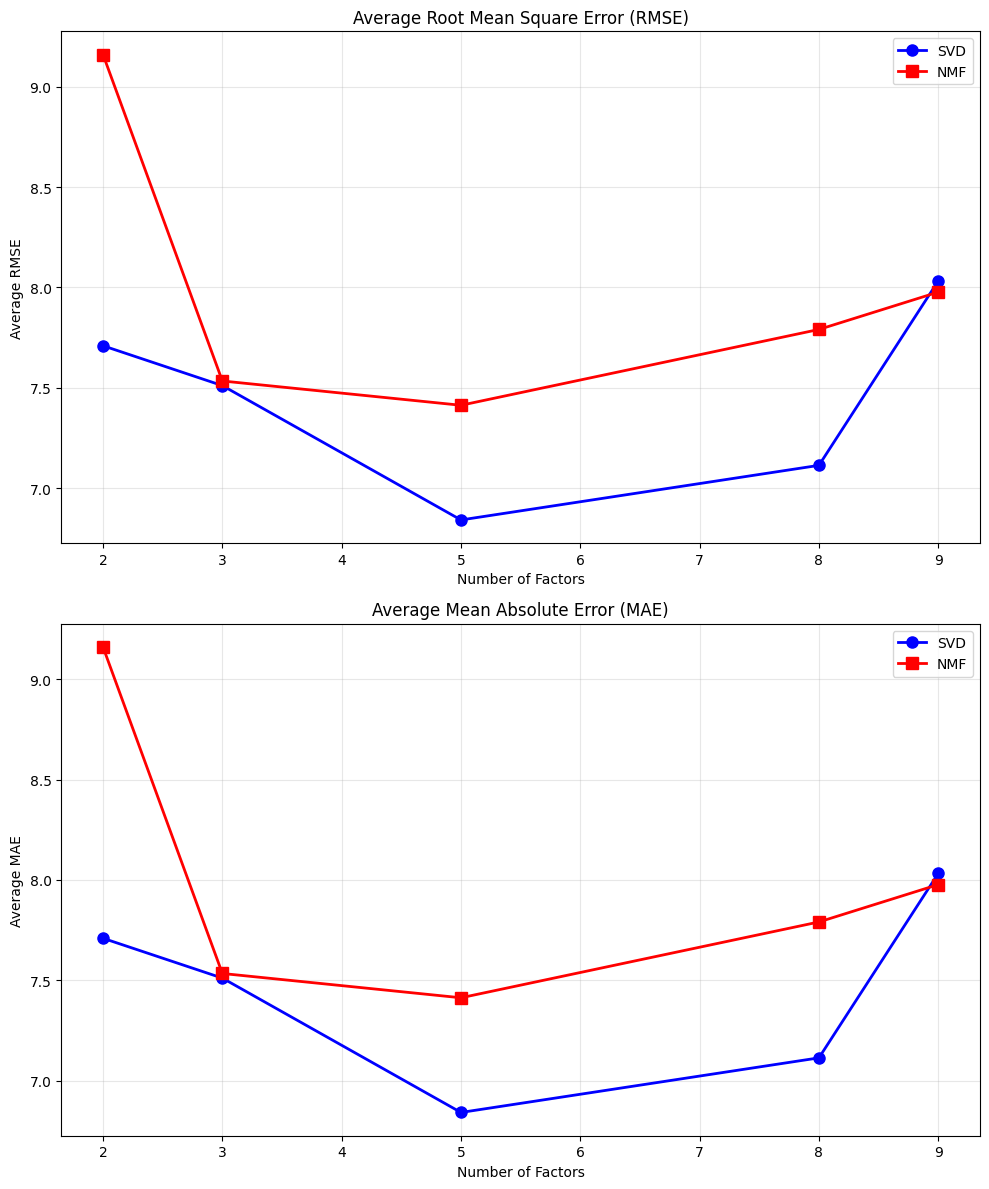

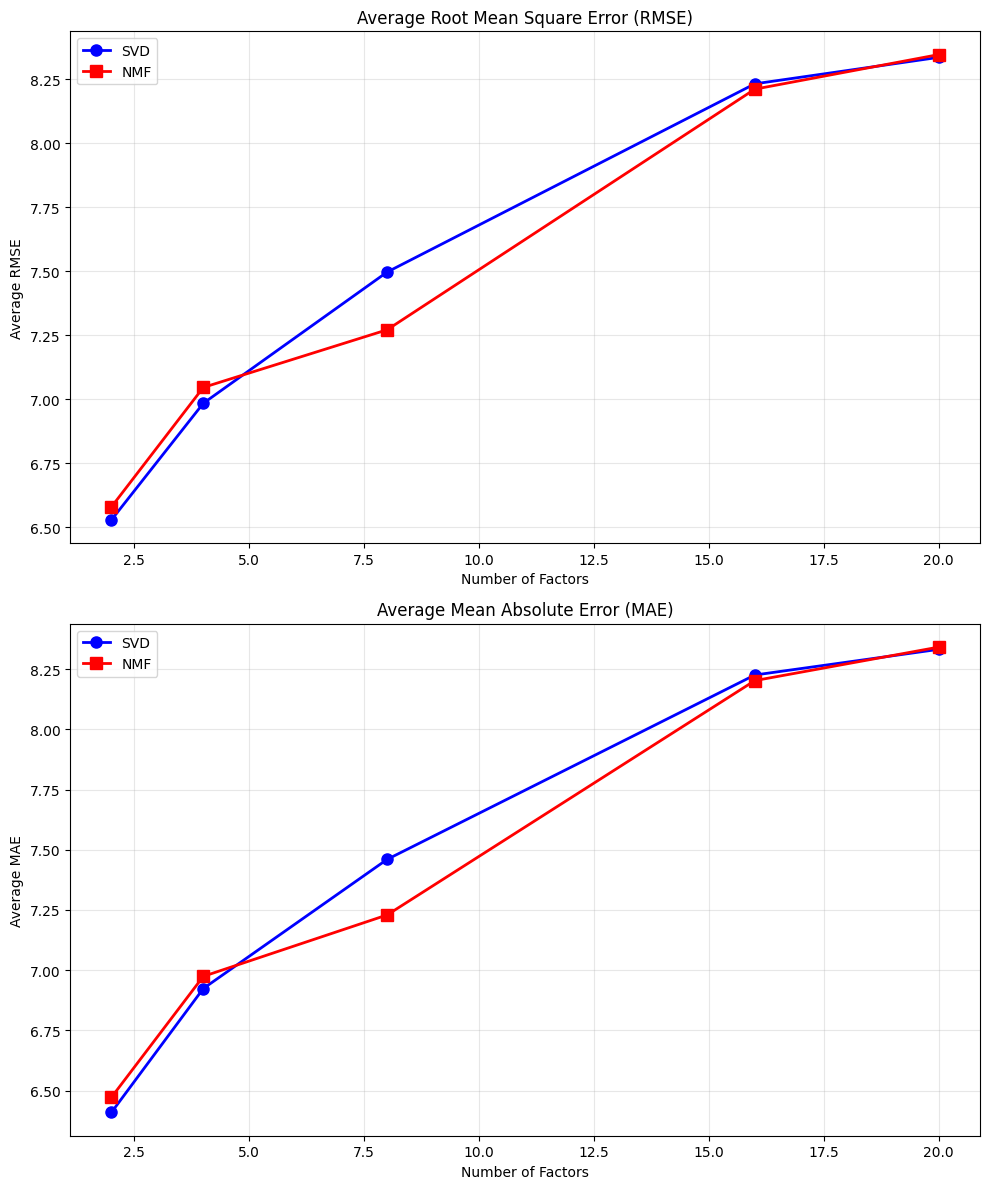

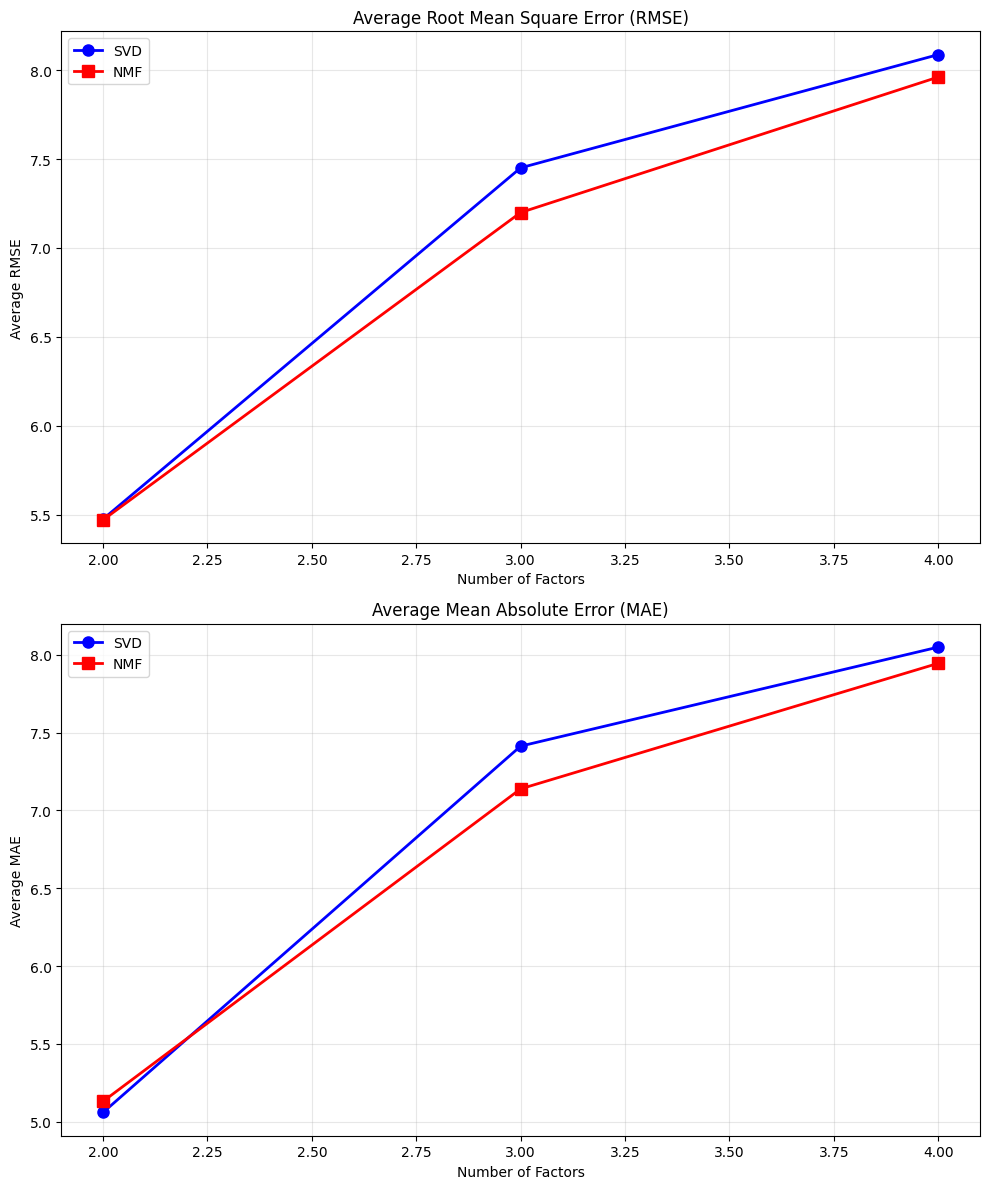


Analyzing optimal configurations...

Optimization Summary (Based on Average Metrics):

COUNTRY_OF_ORIGIN:
-----------------
Best Model: SVD
Optimal Factors: 5
Performance:
  Average RMSE: 6.843
  Average MAE:  6.843

VARIETY:
-------
Best Model: SVD
Optimal Factors: 2
Performance:
  Average RMSE: 6.528
  Average MAE:  6.409

PROCESSING_METHOD:
-----------------
Best Model: SVD
Optimal Factors: 2
Performance:
  Average RMSE: 5.475
  Average MAE:  5.059


In [21]:
# Create the optimizer with the dataset
optimizer = CoffeeRecommenderOptimizer(loaded_df)

# Run the full evaluation
print("Starting comprehensive model evaluation...")
results = optimizer.evaluate_configurations()

# Visualize the results
print("\nGenerating performance visualizations...")
optimizer.visualize_results(results)

# Find and display the optimal configurations
print("\nAnalyzing optimal configurations...")
optimal_configs = optimizer.find_optimal_configuration(results)
optimizer.print_optimization_summary(optimal_configs)